# Benchmark pure pipeline:

Runtime comparison, of the translated pipelines.

## Required packages:
See: requirements/requirements.txt and requirements/requirements.dev.txt


## Some parameters you might want to set:

In [ ]:
import pathlib
import timeit
from inspect import cleandoc
import matplotlib.pyplot as plt

from mlinspect.to_sql.dbms_connectors.postgresql_connector import PostgresqlConnector
from mlinspect.to_sql.dbms_connectors.umbra_connector import UmbraConnector
from pandas_connector import PandasConnector
from mlinspect import PipelineInspector
from mlinspect.utils import get_project_root
from _code_as_string import get_healthcare_pipe_code
from pandas_connector import PandasConnector
from _benchmark_utility import plot_compare, ROOT_DIR, PLOT_DIR
from _code_as_string import Join, GroupBy, Selection, Projection

DO_CLEANUP = True
SIZES = [(10 ** i) for i in range(2, 5, 1)]
BENCH_REP = 10
MLINSPECT_ROOT_DIR = get_project_root()

# DBMS related:
UMBRA_DIR = r"/home/luca/Documents/Bachelorarbeit/umbra-students"
UMBRA_USER = "postgres"
UMBRA_PW = " "
UMBRA_DB = ""
UMBRA_PORT = 5433
UMBRA_HOST = "/tmp/"

POSTGRES_USER = "luca"
POSTGRES_PW = "password"
POSTGRES_DB = "healthcare_benchmark"
POSTGRES_PORT = 5432
POSTGRES_HOST = "localhost"

# Data Generation

To be able to benchmark and compare the different approaches, some datasets
will need to be generated before. The datasets are just and expansion of the
original ones.

In [2]:
!{sys.executable} -m pip install faker

from data_generation.compas_data_generation import generate_compas_dataset
from data_generation.healthcare_data_generation import generate_healthcare_dataset

# We only generate the files, that are not already existing:

COMPAS_DATA_PATHS = generate_compas_dataset(SIZES)
HEALTHCARE_DATA_PATHS = generate_healthcare_dataset(SIZES)

Data generated or found for: size = 100 -- compas
Data generated or found for: size = 1000 -- compas
Data generated or found for: size = 10000 -- compas
Data generated or found for: size = 100 -- healthcare
Data generated or found for: size = 1000 -- healthcare
Data generated or found for: size = 10000 -- healthcare


## Demo:

In [8]:
def get_healthcare_sql_str(pipeline_code, mode, materialize):
    PipelineInspector \
        .on_pipeline_from_string(pipeline_code) \
        .execute_in_sql(dbms_connector=None, mode=mode, materialize=materialize)

    setup_file = \
        pathlib.Path(MLINSPECT_ROOT_DIR / r"mlinspect/to_sql/generated_code/create_table.sql")
    test_file = \
        pathlib.Path(MLINSPECT_ROOT_DIR / r"mlinspect/to_sql/generated_code/pipeline.sql")

    with setup_file.open("r") as file:
        setup_code = file.read()

    with test_file.open("r") as file:
        test_code = file.read()

    return setup_code, test_code

ITERATION: 0 - for table size of: 100

Just translation to SQL is performed! 
-> SQL-Code placed at: mlinspect/to_sql/generated_code



No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


Executing Query in Umbra...
Done in 0.0005289!
Executing Query in Postgres...
Done in 0.3949999999999999!
Executing Query in Pandas...
Done in 12.925292799991439!
ITERATION: 1 - for table size of: 1000

Just translation to SQL is performed! 
-> SQL-Code placed at: mlinspect/to_sql/generated_code



Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


Executing Query in Umbra...
Done in 0.0009695999999999999!
Executing Query in Postgres...
Done in 2.0067!
Executing Query in Pandas...
Done in 12.088620800022909!
ITERATION: 2 - for table size of: 10000

Just translation to SQL is performed! 
-> SQL-Code placed at: mlinspect/to_sql/generated_code



Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


Executing Query in Umbra...
Done in 0.0033541999999999995!
Executing Query in Postgres...
Done in 20.8049!
Executing Query in Pandas...
Done in 29.755520800063096!
Plotting..


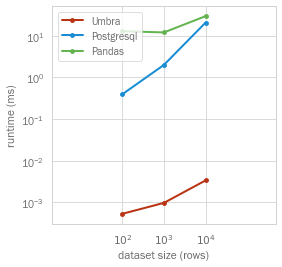

In [9]:
def pure_pipeline_benchmark():
    umbra_times = []
    postgres_times = []
    pandas_times = []

    postgres = PostgresqlConnector(dbname="healthcare_benchmark", user="luca", password="password", port=5432,
                                   host="localhost")
    pandas = PandasConnector()

    for i, (path_to_csv_his, path_to_csv_pat) in enumerate(HEALTHCARE_DATA_PATHS):
        print(f"ITERATION: {i} - for table size of: {SIZES[i]}")

        setup_code_orig, test_code_orig = get_healthcare_pipe_code(path_to_csv_his, path_to_csv_pat)

        setup_code, test_code = get_healthcare_sql_str(setup_code_orig + "\n" + test_code_orig, mode="CTE",
                                                       materialize=False)

        ################################################################################################################
        # time Umbra:
        umbra = UmbraConnector(dbname="", user="postgres", password=" ", port=5433, host="/tmp/", umbra_dir=UMBRA_DIR)
        umbra.run(setup_code)
        umbra_times.append(umbra.benchmark_run(test_code, repetitions=BENCH_REP))

        ################################################################################################################
        # time Postgres:
        postgres.run(setup_code)
        postgres_times.append(postgres.benchmark_run(test_code, repetitions=BENCH_REP))

        ################################################################################################################
        # time Pandas:
        pandas_times.append(pandas.benchmark_run(pandas_code=test_code_orig, setup_code=setup_code_orig,
                                                 repetitions=BENCH_REP))
        ################################################################################################################

    print(f"Plotting..")
    names = ["Umbra", "Postgresql", "Pandas"]
    title = "HealthcarePurePipeComparison"
    table = [umbra_times, postgres_times, pandas_times]
    plot_compare(title, SIZES, all_y=table, all_y_names=names, save=True)

pure_pipeline_benchmark()

### The original results:
**Join**:

![](./plots/HealthcarePurePipeComparison.png)


In [10]:
# Clean_up:
if DO_CLEANUP:
    [f.unlink() for f in PLOT_DIR.glob("*_.png") if f.is_file()]